In [31]:
import sys
sys.path.insert(0, '/home/sxh/Research/AttentiveFP/code',)

import os
os.environ["CUDA_VISIBLE_DEVICES"] ="5"

In [32]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight


In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [34]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

In [35]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
        loss.backward()
        optimizer.step()

        
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)            
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
    test_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
#     test_prc = auc(recall, precision)
    test_precision = [precision_score(y_val_list[i],
                                     (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_recall = [recall_score(y_val_list[i],
                               (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()
    
    return test_roc, test_prc, test_precision, test_recall, test_loss



def predict(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)

    
    return pd.DataFrame(y_pred_list).values

number of all smiles:  1484
not successfully processed smiles:  [NH4][Pt]([NH4])(Cl)Cl
not successfully processed smiles:  c1ccc(cc1)n2c(=O)c(c(=O)n2c3ccccc3)CCS(=O)c4ccccc4


RDKit ERROR: [23:56:53] Explicit valence for atom # 0 N, 5, is greater than permitted
RDKit ERROR: [23:56:53] Can't kekulize mol.  Unkekulized atoms: 9
RDKit ERROR: 
RDKit ERROR: [23:56:53] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [23:56:53] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [23:56:53] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 
RDKit ERROR: [23:56:53] Can't kekulize mol.  Unkekulized atoms: 4
RDKit ERROR: 


not successfully processed smiles:  Cc1cc2c(cc1C)N3C=N2[Co+]456(N7=C8[C@H](C(C7=CC9=N4C(=C(C1=N5[C@@]([C@@H]2N6C(=C8C)[C@@]([C@H]2CC(=O)N)(CCC(=O)NC[C@H](OP(=O)(O[C@@H]2[C@H](O[C@H]3[C@@H]2O)CO)[O-])C)C)([C@@]([C@@H]1CCC(=O)N)(C)CC(=O)N)C)C)[C@@]([C@@H]9CCC(=O)N)(C)CC(=O)N)(C)C)CCC(=O)N)O
not successfully processed smiles:  Cc1cc2c(cc1C)N3C=N2[Co]456(N7=C8[C@H](C(C7=CC9=N4C(=C(C1=N5[C@@]([C@@H]2N6C(=C8C)[C@@]([C@H]2CC(=O)N)(CCC(=O)NC[C@H](OP(=O)(O[C@@H]2[C@H](O[C@H]3[C@@H]2O)CO)O)C)C)([C@@]([C@@H]1CCC(=O)N)(C)CC(=O)N)C)C)[C@@]([C@@H]9CCC(=O)N)(C)CC(=O)N)(C)C)CCC(=O)N)C#N
not successfully processed smiles:  CCCCc1c(=O)n(n(c1=O)c2ccc(cc2)O)c3ccccc3
not successfully processed smiles:  CCCCc1c(=O)n(n(c1=O)c2ccccc2)c3ccccc3
number of successfully processed smiles:  1478


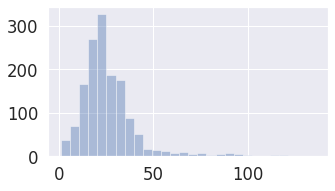

In [36]:
tasks = [ 'FDA_APPROVED','CT_TOX']
raw_filename = "/home/sxh/Research/AttentiveFP/data/clintox.csv"

feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [37]:
random_seed = 888
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.5
fingerprint_dim = 200

radius = 3
T = 3
weight_decay = 3 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [38]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<151]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

,smiles,FDA_APPROVED,CT_TOX,cano_smiles
12,[Se],0,1,[Se]
20,C(#N)[Fe-2](C#N)(C#N)(C#N)(C#N)N=O,1,0,N#C[Fe-2](C#N)(C#N)(C#N)(C#N)N=O


In [39]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])


In [42]:
remained_df = remained_df.reset_index(drop=True)
task_name = 'ClinTox'


for seed in [2, 32, 128, 512, 1024]:
    for fold in [0,1,2,3,4]: #
        
        print(seed, fold)
        df_test = pd.read_csv('./%s/seed_%s/fold_%s/test.csv' % (task_name, seed, fold))
        df_valid = pd.read_csv('./%s/seed_%s/fold_%s/valid.csv' % (task_name,seed,  fold))
        df_train = pd.read_csv('./%s/seed_%s/fold_%s/train.csv' % (task_name,seed, fold))

        pred = './%s/seed_%s/fold_%s/pred_test.csv' % (task_name, seed, fold)
        pred2 = './%s/seed_%s/fold_%s/pred_valid.csv' % (task_name,seed,  fold)
        if (os.path.exists(pred)) & (os.path.exists(pred2)):
            continue

        test_df = remained_df[remained_df.smiles.isin(df_test.smiles)].reset_index(drop=True)
        valid_df = remained_df[remained_df.smiles.isin(df_valid.smiles)].reset_index(drop=True)
        train_df = remained_df[remained_df.smiles.isin(df_train.smiles)].reset_index(drop=True)


        print(len(train_df),len(valid_df),len(test_df),)

        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
        num_atom_features = x_atom.shape[-1]
        num_bond_features = x_bonds.shape[-1]

        loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight)) for weight in weights]
        model = Fingerprint(radius, T, num_atom_features,num_bond_features,
                    fingerprint_dim, output_units_num, p_dropout)
        model.cuda()
        optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

        best_param ={}
        best_param["roc_epoch"] = 0
        best_param["loss_epoch"] = 0
        best_param["valid_roc"] = 0
        best_param["valid_loss"] = 9e8

        for epoch in range(epochs):    
            train_roc, train_prc, train_precision, train_recall, train_loss = eval(model, train_df)
            valid_roc, valid_prc, valid_precision, valid_recall, valid_loss = eval(model, valid_df)
            train_roc_mean = np.array(train_roc).mean()
            valid_roc_mean = np.array(valid_roc).mean()

            if valid_roc_mean > best_param["valid_roc"]:
                best_param["roc_epoch"] = epoch
                best_param["valid_roc"] = valid_roc_mean
                if valid_roc_mean > 0.68:
                     torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')

            if valid_loss < best_param["valid_loss"]:
                best_param["loss_epoch"] = epoch
                best_param["valid_loss"] = valid_loss

            print("EPOCH:\t"+str(epoch)+'\n'\
                +"train_roc"+":"+str(train_roc)+'\n'\
                +"valid_roc"+":"+str(valid_roc)+'\n')
            if epoch - best_param["roc_epoch"] > 15:        
                break

            train(model, train_df, optimizer, loss_function)

        # evaluate model
        best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     

        test_roc, test_prc, test_precision, test_recall, test_losses = eval(best_model, test_df)

        print("best epoch:"+str(best_param["roc_epoch"])
              +"\n"+"test_roc:"+str(test_roc)
              +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
             )

        pred_test = predict(best_model, test_df)
        
        pd.DataFrame(pred_test, index = test_df['smiles'],
                     columns = [tasks]).to_csv('./%s/seed_%s/fold_%s/pred_test.csv' % (task_name, seed, fold))

        pd.DataFrame(test_df[tasks].values, index = test_df['smiles'],
                     columns = [tasks]).to_csv('./%s/seed_%s/fold_%s/test.csv' % (task_name,seed,  fold))

        pred_valid = predict(best_model, valid_df)
        pd.DataFrame(pred_valid, index = valid_df['smiles'], 
                     columns = [tasks]).to_csv('./%s/seed_%s/fold_%s/pred_valid.csv' % (task_name, seed, fold))

        pd.DataFrame(valid_df[tasks].values, index = valid_df['smiles'],
                     columns = [tasks]).to_csv('./%s/seed_%s/fold_%s/valid.csv' % (task_name, seed,  fold))

2 0
2 1
2 2
2 3
2 4
32 0
32 1
32 2
32 3
32 4
128 0
128 1
128 2
128 3
128 4
512 0
512 1
512 2
512 3
512 4
1024 0
1024 1
1024 2
1024 3
1024 4
